In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture

In [2]:
data = pd.read_csv("../../Data/MIGHTEE/1.4_to_150/Lockman_150MHz_and_1.4 GHz.csv")

In [3]:
datalog = np.log10(data)

/var/lib/condor/execute/dir_3067959/ipykernel_3070753/3100607013.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.ax_joint.set_yticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])
/var/lib/condor/execute/dir_3067959/ipykernel_3070753/3100607013.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.ax_joint.set_xticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])


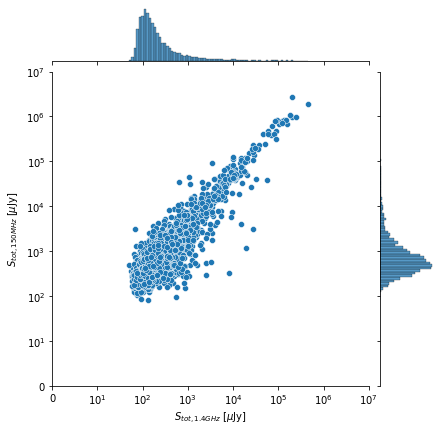

In [4]:
ax = sns.jointplot(data=datalog, x='Stot', y='Total_flux', xlim=[0,7], ylim=[0,7])
ax.set_axis_labels(r"$S_{tot, 1.4GHz} \; [\mu$Jy]", r"$S_{tot, 150MHz} \; [\mu$Jy]")
ax.ax_joint.set_yticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])
ax.ax_joint.set_xticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])
plt.savefig("1.4_vs_150_total.pdf")
plt.show()

/var/lib/condor/execute/dir_3067959/ipykernel_3070753/2946193652.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.ax_joint.set_yticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])
/var/lib/condor/execute/dir_3067959/ipykernel_3070753/2946193652.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.ax_joint.set_xticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])


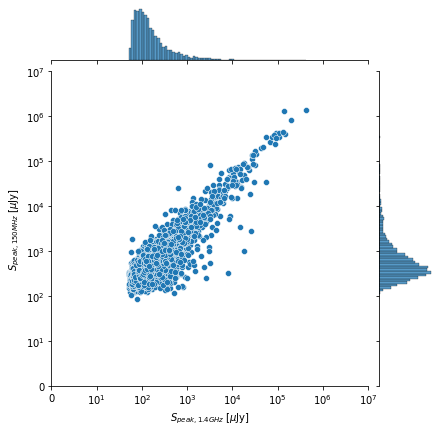

In [5]:
ax = sns.jointplot(data=datalog, x='Speak', y='Peak_flux', xlim=[0,7], ylim=[0,7])
ax.set_axis_labels(r"$S_{peak, 1.4GHz} \; [\mu$Jy]", r"$S_{peak, 150MHz} \; [\mu$Jy]")
ax.ax_joint.set_yticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])
ax.ax_joint.set_xticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])
plt.savefig("1.4_vs_150_peak.pdf")
plt.show()

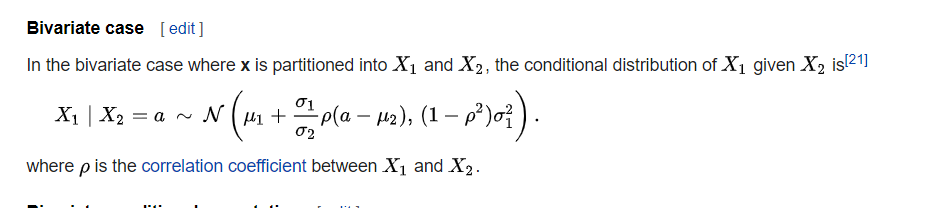

In [6]:
def conditional(mus, cov, a):
    """
    Function to calculate the gaussian of a bivariate normal distribution given the condition that x2==a
    
    returns new mean and new std
    """
    # Definitions
    std1 = cov[0,0]**.5
    std2 = cov[1,1]**.5
    std12 = cov[0,1]
    
    mu1 = mus[0]
    mu2 = mus[1]
    
    # Correlation coefficient
    rho = std12/(std1 * std2)
    
    mu_new = mu1 + std1/std2 * rho * (a - mu2)
    std_new = (1 - rho**2)*std1**2
    
    return mu_new, std_new

Means: [2.15532179 2.75998309]


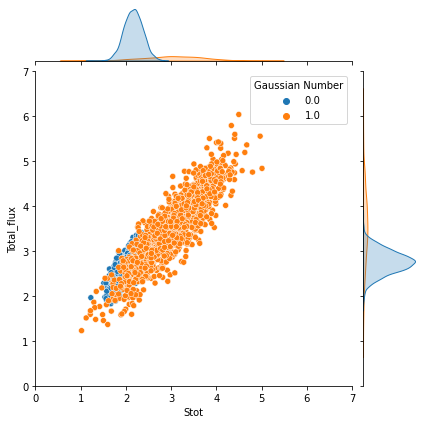

In [7]:
gm_tot = GaussianMixture(n_components=2, random_state=0).fit(datalog[['Stot', 'Total_flux']])
print('Means:', gm_tot.means_[0])

# Sampling the gaussians
sample = gm_tot.sample(5000)
sample_values = sample[0]
sample_gaussian = sample[1]
sample_data = pd.DataFrame(data=np.array([sample_values[:,0], sample_values[:,1], sample_gaussian]).T,
                          columns=['Stot', 'Total_flux', 'Gaussian Number'])


sns.jointplot(data=sample_data, x='Stot', y='Total_flux', hue='Gaussian Number', xlim=[0,7], ylim=[0,7])

Means: [2.15532179 2.75998309]


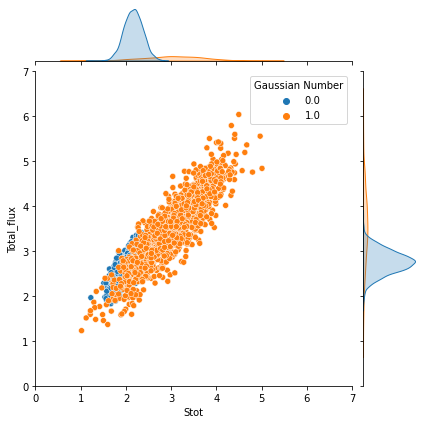

In [8]:
gm_tot = GaussianMixture(n_components=2, random_state=0).fit(datalog[['Stot', 'Total_flux']])
print('Means:', gm_tot.means_[0])

# Sampling the gaussians
sample = gm_tot.sample(5000)
sample_values = sample[0]
sample_gaussian = sample[1]
sample_data = pd.DataFrame(data=np.array([sample_values[:,0], sample_values[:,1], sample_gaussian]).T,
                          columns=['Stot', 'Total_flux', 'Gaussian Number'])


sns.jointplot(data=sample_data, x='Stot', y='Total_flux', hue='Gaussian Number', xlim=[0,7], ylim=[0,7])

## Analysis of number of clusters

### BIC

#### Peak

In [91]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=100)

X = datalog[['Speak', 'Peak_flux']]

scores = []
for n in [1,2,3,4,5,6,7,8,9]:
    score_per_n = []
    for train, test in kf.split(X):
        # split gives the indices
        X_train = X.iloc[train]
        X_test = X.iloc[test]
        
        gm_tot = GaussianMixture(n_components=n).fit(X_train)
        
        score = gm_tot.bic(X_test)
        score_per_n.append(score)
    scores.append(score_per_n)

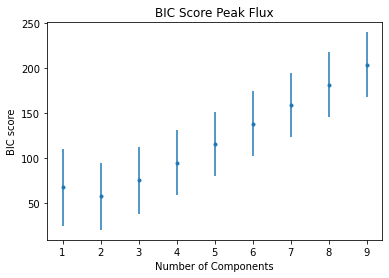

In [92]:
mean_score = np.mean(scores, axis=1)
std = np.std(scores, axis=1)
plt.errorbar([1,2,3,4,5,6,7,8,9], mean_score, yerr=std, fmt='.')
plt.xlabel("Number of Components")
plt.ylabel("BIC score")
plt.title("BIC Score Peak Flux")
plt.savefig("BIC_scores_peak.pdf")
plt.show()

# Lower is better

#### Total

In [93]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=100)

X = datalog[['Stot', 'Total_flux']]

scores = []
for n in [1,2,3,4,5,6,7,8,9]:
    score_per_n = []
    for train, test in kf.split(X):
        # split gives the indices
        X_train = X.iloc[train]
        X_test = X.iloc[test]
        
        gm_tot = GaussianMixture(n_components=n).fit(X_train)
        
        score = gm_tot.bic(X_test)
        score_per_n.append(score)
    scores.append(score_per_n)

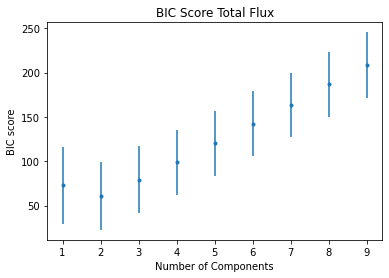

In [94]:
mean_score = np.mean(scores, axis=1)
std = np.std(scores, axis=1)
plt.errorbar([1,2,3,4,5,6,7,8,9], mean_score, yerr=std, fmt='.')
plt.xlabel("Number of Components")
plt.ylabel("BIC score")
plt.title("BIC Score Total Flux")
plt.savefig("BIC_scores_tot.pdf")
plt.show()

# Lower is better

### silhouette_score

In [84]:
from sklearn.metrics import silhouette_score

scores = []
for n in [2,3,4,5,6,7,8,9]:
    score_per_n = []
    for train, test in kf.split(X):
        # split gives the indices
        X_train = X.iloc[train]
        X_test = X.iloc[test]
        
        gm_tot = GaussianMixture(n_components=n).fit(X_train)
        
        score = gm_tot.bic(X_test)
        score_per_n.append(score)
    scores.append(score_per_n)

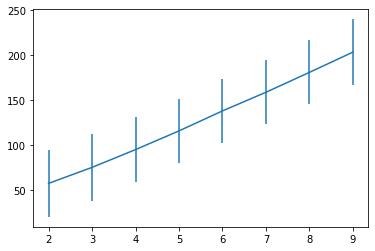

In [85]:
mean_score = np.mean(scores, axis=1)
std = np.std(scores, axis=1)
plt.errorbar([2,3,4,5,6,7,8,9], mean_score, yerr=std)
plt.show()

# Higher is better

### Overlaying fit with data

In [10]:
from scipy.stats import multivariate_normal

covs = gm_tot.covariances_[0]
mus = gm_tot.means_[0]
samples1 = multivariate_normal.rvs(mean=mus, cov=covs, size=10000)

covs = gm_tot.covariances_[1]
mus = gm_tot.means_[1]
samples2 = multivariate_normal.rvs(mean=mus, cov=covs, size=10000)

/var/lib/condor/execute/dir_3067959/ipykernel_3070753/3719586879.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.ax_joint.set_yticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])
/var/lib/condor/execute/dir_3067959/ipykernel_3070753/3719586879.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.ax_joint.set_xticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])


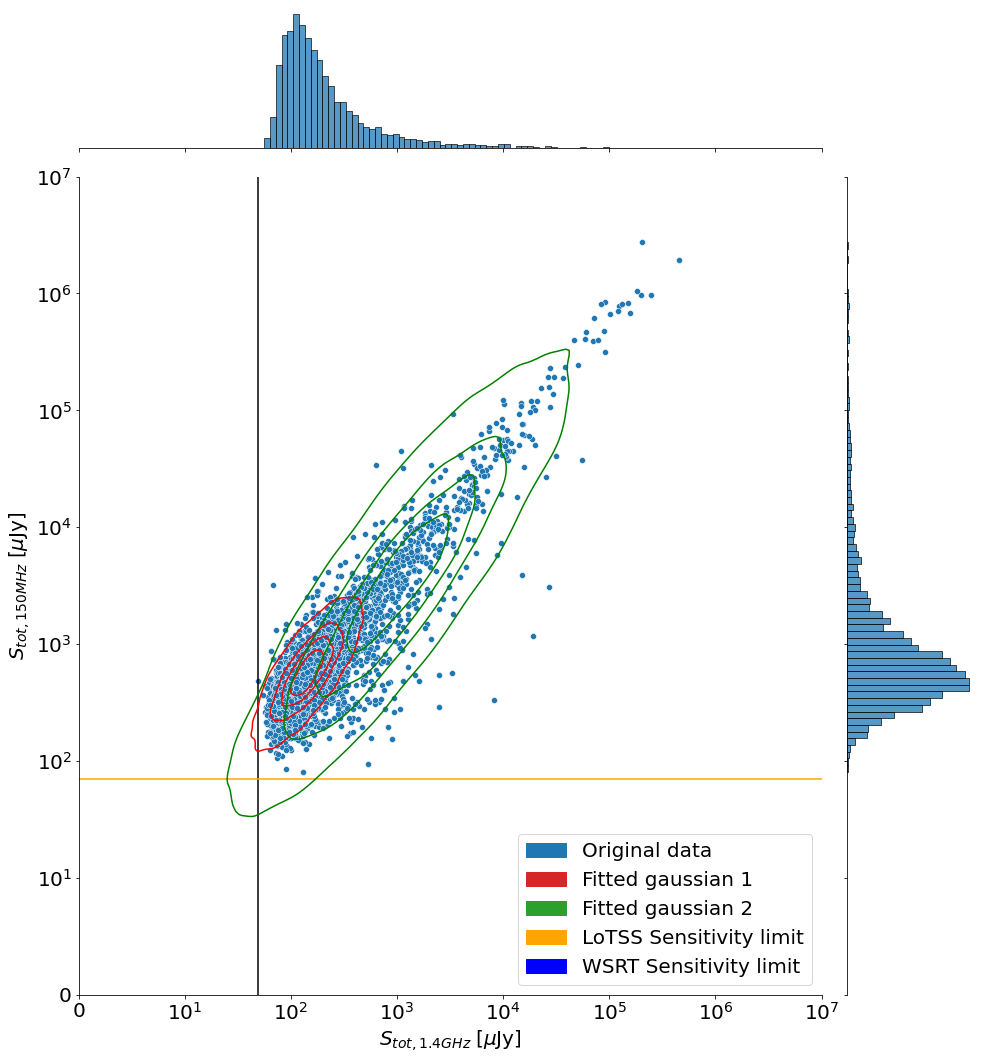

In [11]:
import matplotlib.patches as mpatches
from matplotlib import rcParams

rcParams.update({'font.size': 20})

ax = sns.jointplot(data=datalog, x='Stot', y='Total_flux', xlim=[0,7], ylim=[0,7], height=15)
ax.set_axis_labels(r"$S_{tot, 1.4GHz} \; [\mu$Jy]", r"$S_{tot, 150MHz} \; [\mu$Jy]")
ax.ax_joint.set_yticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])
ax.ax_joint.set_xticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])


# First Gaussian
ax.x = samples1[:,0]
ax.y = samples1[:,1]
ax.plot_joint(sns.kdeplot, color="r", zorder=3, levels=5)

# Second Gaussian
ax.x = samples2[:,0]
ax.y = samples2[:,1]
ax.plot_joint(sns.kdeplot, color="g", zorder=3, levels=5)


# Sensitivity limit LOFAR
ax.x = [0,8]
ax.y = [np.log10(71), np.log10(71)]
ax.plot_joint(sns.lineplot, color='orange', linewidth = 1.5)

# Sensitivity limit WSRT
ax.ax_joint.vlines(np.log10(49), 0, 8, color='k')

blue_patch = mpatches.Patch(color='#1f77b4', label='Original data')
red_patch = mpatches.Patch(color='#d62728', label='Fitted gaussian 1')
green_patch = mpatches.Patch(color='#2ca02c', label='Fitted gaussian 2')
orange_patch = mpatches.Patch(color='orange', label='LoTSS Sensitivity limit')
black_patch = mpatches.Patch(color='b', label='WSRT Sensitivity limit')
plt.legend(loc='lower right', 
           handles=[blue_patch, red_patch, green_patch,orange_patch,black_patch], 
           bbox_to_anchor=(-0.2, 0))

plt.subplots_adjust(left=0.15)
plt.savefig("1.4_vs_150_total_fitted.png")
plt.show()

In [24]:
ax.ax_joint.axhline(5)

<AxesSubplot:xlabel='$S_{tot, 1.4GHz} \\; [\\mu$Jy]', ylabel='$S_{tot, 150MHz} \\; [\\mu$Jy]'>

In [48]:
dir(ax.fig.axes[0].plot)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

# Generating new data

## Total

In [12]:
newdata = pd.read_csv("../../Data/MIGHTEE/Classification/Combined_secure_postprocessed.csv")

In [13]:
gm_tot.covariances_

array([[[0.24222983, 0.2319561 ],
        [0.2319561 , 0.27649527]]])

In [14]:
cov = gm_tot.covariances_
mus = gm_tot.means_[0]

In [15]:
len(newdata)

5121

In [16]:
tot14 = np.log10(newdata['S_INT14'])

In [17]:
new_mu, new_cov = conditional(mus[::-1], cov.T, tot14)

In [18]:
tot150 = np.random.normal(new_mu, new_cov**.5)

/var/lib/condor/execute/dir_938926/ipykernel_941788/2666845218.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.ax_joint.set_yticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])
/var/lib/condor/execute/dir_938926/ipykernel_941788/2666845218.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.ax_joint.set_xticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])


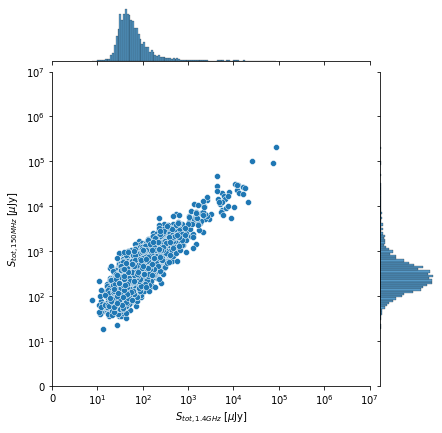

In [19]:
tot_comparison = pd.DataFrame(data=np.array([tot14, tot150]).T, columns=['Total Flux 1.4 GHz', 'Total Flux 150 MHz'])
ax = sns.jointplot(data=tot_comparison, x='Total Flux 1.4 GHz', y='Total Flux 150 MHz', xlim=[0,7], ylim=[0,7])
ax.set_axis_labels(r"$S_{tot, 1.4GHz} \; [\mu$Jy]", r"$S_{tot, 150MHz} \; [\mu$Jy]")
ax.ax_joint.set_yticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])
ax.ax_joint.set_xticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])
plt.savefig("1.4_vs_150_total_generated.pdf")

## Peak

In [20]:
gm_peak = GaussianMixture(n_components=1, random_state=0).fit(datalog[['Speak', 'Peak_flux']])

In [21]:
cov = gm_peak.covariances_
mus = gm_peak.means_[0]

In [22]:
peak14 = np.log10(newdata['S_PEAK14'])

In [23]:
new_mu, new_cov = conditional(mus[::-1], cov.T, peak14)

In [24]:
peak150 = np.random.normal(new_mu, new_cov**.5)

/var/lib/condor/execute/dir_938926/ipykernel_941788/610053511.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.ax_joint.set_yticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])
/var/lib/condor/execute/dir_938926/ipykernel_941788/610053511.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.ax_joint.set_xticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])


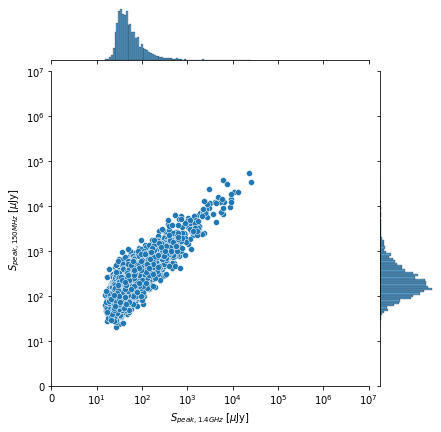

In [25]:
peak_comparison = pd.DataFrame(data=np.array([peak14, peak150]).T, columns=['Peak Flux 1.4 GHz', 'Peak Flux 150 MHz'])
ax = sns.jointplot(data=peak_comparison, x='Peak Flux 1.4 GHz', y='Peak Flux 150 MHz', xlim=[0,7], ylim=[0,7])
ax.set_axis_labels(r"$S_{peak, 1.4GHz} \; [\mu$Jy]", r"$S_{peak, 150MHz} \; [\mu$Jy]")
ax.ax_joint.set_yticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])
ax.ax_joint.set_xticklabels(['0', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$'])
plt.savefig("1.4_vs_150_peak_generated.pdf")

## Saving to a file

In [487]:
newdata['Total_flux'] = 10**tot150
newdata['Peak_flux'] = 10**peak150

In [488]:
newdata.to_csv("../../Data/MIGHTEE/Classification/final_gaussian_radio_secure.csv")

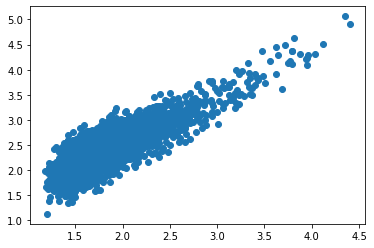

In [489]:
plt.scatter(peak14, peak150)